In [11]:
import scipy
import math
import numpy as np
from diagonalize import State, delta, neg_1_pow, Interaction, Molecule
import matplotlib.pyplot as plt
from tqdm import tqdm

int_wigner_arr = np.load("wigner3j_integer_N=10.npy")
halfint_wigner_arr = np.load("wigner3j_halfint_N=3.5.npy")

def T_int(n3, n1, m3, m1, n2, m2, N=10):
    m1_ = m1 + N
    m2_ = m2 + 2
    m3_ = m3 + N
    
    return m2_ + 5*n2 + 15*m1_ + (15 + 30*N)*m3_ + (15+ 60*N + 60*N*N)*n1 + (15 + 75*N + 120*N*N + 60 *N*N*N)*n3

def T_half_int(n3, n1, m3, m1, n2, m2, N = 7/2):
    n3 = n3 - 0.5 
    n1 = n1 - 0.5 
    
    n2 = n2
    m2 = m2 + 2 
    
    m3 = m3 + N 
    m1 = m1 + N 
    
    return int(m2     + 5 * n2         + 15 * m1               + (15+30*N)*m3  + (15+60*N+60*N*N)*n1     + (60*N*N*N + 90*N*N + 45*N + 7.5)*n3)
    
def wigner_3j(n1, n2, n3, m1, m2, m3):
    if n1 == int(n1) and n2 == int(n2) and n3 == int(n3):
        return int_wigner_arr[T_int(n3,n1,m3,m1,n2,m2)]
    return halfint_wigner_arr[T_half_int(n3,n1,m3,m1,n2,m2)]

h = scipy.constants.h
muN = scipy.constants.physical_constants['nuclear magneton'][0]
bohr = scipy.constants.physical_constants['Bohr radius'][0]
eps0 = scipy.constants.epsilon_0
c = scipy.constants.c
DebyeSI = 3.33564e-30

Na23Cs133 = {"I1":1.5,
            "I2":3.5,
            "g1":1.478,
            "g2":0.738,
            "d0":4.69*DebyeSI,
            "Brot":0.058*c*100*h,
            "Drot":0*h,
            "Q1":-0.097e6*h,
            "Q2":0.150e6*h,
            "C1":14.2*h,
            "C2":854.5*h,
            "C3":105.6*h,
            "C4":3941.8*h,
            "MuN":0*muN,
            "Mu1":1.478*muN,
            "Mu2":0.738*muN,
            "a0":0*h, #Not reported
            "a2":0*h, #Not reported
            "Beta":0}

def rotational(state1: State, state2:State):
    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()

    if delta(n, n_) and delta(mn, mn_) and delta(m1, m1_) and delta(m2, m2_):
        return n*(n+1)
    return 0

def stark(state1: State, state2:State):
    
    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not (delta(mn, mn_) and delta(m1, m1_) and delta(m2, m2_)):
        return 0
    
    wig1 = wigner_3j(n, 1, n_, -mn, 0, mn)
    if wig1 == 0:
        return 0
    
    wig2 = wigner_3j(n, 1, n_, 0, 0, 0)
    if wig2 == 0:
        return 0
    
    other = -neg_1_pow(mn+m1+m2) * math.sqrt((2*n + 1) * (2*n_ + 1))
    return wig1 * wig2 * other

from scipy.constants import physical_constants
from scipy.constants import c
from scipy.constants import epsilon_0

int_rotational = Interaction(Na23Cs133["Brot"], rotational)
int_stark = Interaction(Na23Cs133["d0"], stark)
NaCs = Molecule(range(11), 0, 0)
NaCs.add_interaction(int_rotational)
NaCs.add_changing_interaction(int_stark)

NaCs.find_H_zero()
NaCs.find_H_prime()

E_range = np.linspace(0, 10, int(60)) * 1e5
eigenvalues_and_eigenvectors_E_1 = NaCs.compute_eigenval_over_range([E_range[-1:]])
eigenvalues_and_eigenvectors_E_2 = NaCs.compute_eigenval_over_range([E_range[-20:-19]])

eigenvalues_1, eigenvectors_1 = eigenvalues_and_eigenvectors_E_1[0]
eigenvalues_2, eigenvectors_2 = eigenvalues_and_eigenvectors_E_2[0]
basis = NaCs.states

def dipole_dipole_matrix_elem(evec1, evec2, basis):
    if (len(evec1) != len(evec2) or len(evec1) != len(basis)):
        raise('ArithmeticError')
    else:
        value = 0
        for i, a in enumerate(evec1):
            for j, b in enumerate(evec2):
                value += a * b * stark(basis[i], basis[j])
        return value



H has dim 121


In [12]:
N = 10
one_mol_basis_size = (N+1)**2
full_basis_size = (N+1)**4
print(one_mol_basis_size, full_basis_size)

121 14641


In [13]:
eigenvalues_q = np.zeros(full_basis_size)
states1 = np.zeros(full_basis_size)
states2 = np.zeros(full_basis_size)
for s1 in range(one_mol_basis_size):
    for s2 in range(one_mol_basis_size):
        q = s1*one_mol_basis_size + s2
        eigenvalues_q[q] = eigenvalues_1[s1]+eigenvalues_2[s2]
        states1[q] = s1
        states2[q] = s2

states_q = np.zeros((full_basis_size, 3))
for i in range(full_basis_size):
    states_q[i] = np.array([eigenvalues_q[i], states1[i], states2[i]])
states_q = np.array(sorted(states_q, key = lambda x: x[0]))

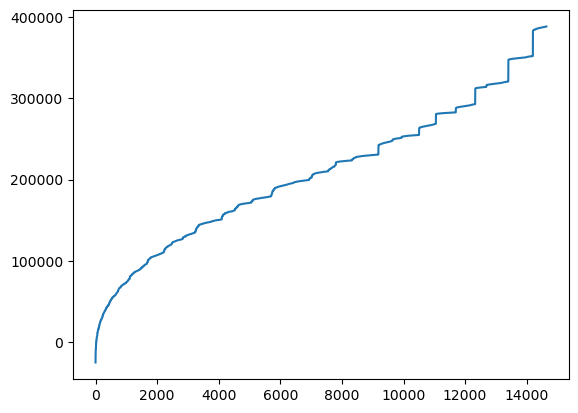

In [14]:
plt.plot(range(full_basis_size), [elem[0]*1e-6/h for elem in states_q])

In [15]:
#dim = len(basis)
#dip_dip_matrix_1 = np.zeros((dim,dim))
#for i in tqdm(range(dim)):
#    for j in range(dim):
#        dip_dip_matrix_1[i][j] = dipole_dipole_matrix_elem(eigenvectors_1[i], eigenvectors_1[j], basis)
#dim = len(basis)
#dip_dip_matrix_2 = np.zeros((dim,dim))
#for i in tqdm(range(dim)):
#    for j in range(dim):
#        dip_dip_matrix_2[i][j] = dipole_dipole_matrix_elem(eigenvectors_2[i], eigenvectors_2[j], basis)


In [16]:
#np.save("dip_dip_matrix1.npy", dip_dip_matrix_1)
#np.save("dip_dip_matrix2.npy", dip_dip_matrix_2)
dip_dip_matrix_1 = np.load("dip_dip_matrix1.npy")
dip_dip_matrix_2 = np.load("dip_dip_matrix2.npy")
        

In [17]:
#H_dd_unitless = np.zeros((full_basis_size,full_basis_size))
#for i in tqdm(range(full_basis_size)):
#    for j in range(full_basis_size):
#        s1 = math.floor(i/one_mol_basis_size)
#        s2 = int(i%one_mol_basis_size)
        
#        s1_ = math.floor(j/one_mol_basis_size)
#        s2_ = int(j%one_mol_basis_size)
        
        #print(s1, s2, s1_, s2_)
#        H_dd_unitless[i][j] += dip_dip_matrix_1[s1_][s1]*dip_dip_matrix_2[s2_][s2]

In [18]:
#np.save("H_dd_unitless.npy", H_dd_unitless)
H_dd_unitless = np.load("H_dd_unitless.npy")